In [1]:
import numpy as np
import matplotlib.pyplot as plt

import chainer.optimizers as Opt
import chainer.functions as F
import chainer.links as L
import chainer.datasets as ds
import chainer.dataset.convert as con
from chainer.iterators import SerialIterator as siter

from chainer import Variable,Chain,config,cuda
from tqdm import tqdm
import princess as ohm

In [2]:
import chainer.datasets as ds
[train,test] = ds.get_cifar10()
[xtrain,ttrain] = con.concat_examples(train)
[xtest,ttest] = con.concat_examples(test)

In [3]:
[Dtrain,ch0,Ny,Nx] = xtrain.shape
print(Dtrain,ch0,Ny,Nx)

50000 3 32 32


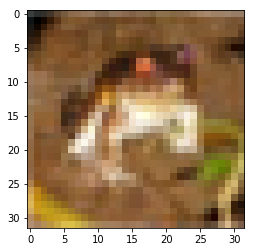

In [4]:
plt.imshow(xtrain[0,:,:,:].transpose(1,2,0))
plt.show()


In [5]:
class ResBlock(Chain):
    def __init__(self, ch):
        layers = {}
        layers['conv1'] = L.Convolution2D(ch,ch,3,1,1)
        layers['conv2'] = L.Convolution2D(ch,ch,3,1,1)
        layers['bnorm1'] = L.BatchNormalization(ch)
        layers['bnorm2'] = L.BatchNormalization(ch)
        super().__init__(**layers)
        
    def __call__(self,x):
        h = self.conv1(x)
        h = F.dropout(h,0.2)
        h = self.bnorm1(h)
        h = F.relu(h)
        h = self.conv2(h)
        h = F.dropout(h,0.2)
        h = self.bnorm2(h)

        return h + x

In [6]:
class CNN(Chain):
    def __init__(self, ch_in,ch_out):
        layers = {}
        layers['conv1'] = L.Convolution2D(ch_in,ch_out,ksize=5,stride=2,pad=2)
        layers['bnorm1'] = L.BatchNormalization(ch_out)
        super().__init__(**layers)
        
    def __call__(self,x):
        h = self.conv1(x)
        #h = F.dropout(h,0.2)
        h = self.bnorm1(h)
        h = F.relu(h)
        #h = F.max_pooling_2d(h,ksize=3,stride=2)

        return h

In [7]:
C = ttrain.max() + 1
H1 = 16
H2 = 32
H3 = 64

NN = Chain(cnn1 = L.Convolution2D(ch0,H1,ksize=1,stride=1,pad=0),
           cnn2 = L.Convolution2D(H1,H1,ksize=3,stride=1,pad=0),
           cnn3 = L.Convolution2D(H1,H1,ksize=5,stride=1,pad=0),
           cnn4 = L.Convolution2D(H1,H2,ksize=1,stride=1,pad=0),
           cnn5 = L.Convolution2D(H2,H2,ksize=3,stride=1,pad=0),
           cnn6 = L.Convolution2D(H2,H2,ksize=5,stride=1,pad=0),
           cnn7 = L.Convolution2D(H2,H3,ksize=1,stride=1,pad=0),
           cnn8 = L.Convolution2D(H3,H3,ksize=3,stride=1,pad=0),
           cnn9 = L.Convolution2D(H3,C,ksize=5,stride=1,pad=3),
           bnorm1 = L.BatchNormalization(H1),
           bnorm2 = L.BatchNormalization(H1),
           bnorm3 = L.BatchNormalization(H1),
           bnorm4 = L.BatchNormalization(H2),
           bnorm5 = L.BatchNormalization(H2),
           bnorm6 = L.BatchNormalization(H2),
           bnorm7 = L.BatchNormalization(H3),
           bnorm8 = L.BatchNormalization(H3),
           #l1 = L.Linear(None,C)
          )


In [8]:
def model(x):
    h = NN.cnn1(x)
    h = F.relu(h)
    h = NN.bnorm1(h)
    h = NN.cnn2(h)
    h = F.relu(h)
    h = NN.bnorm2(h)
    h = NN.cnn3(h)
    h = F.relu(h)
    h = NN.bnorm3(h)
    h = F.max_pooling_2d(h, 2)
    h = NN.cnn4(h)
    h = F.relu(h)
    h = NN.bnorm4(h)
    h = NN.cnn5(h)
    h = F.relu(h)
    h = NN.bnorm5(h)
    h = NN.cnn6(h)
    h = F.relu(h)
    h = NN.bnorm6(h)
    h = F.max_pooling_2d(h, 2)
    h = NN.cnn7(h)
    h = F.relu(h)
    h = NN.bnorm7(h)
    h = NN.cnn8(h)
    h = F.relu(h)
    h = NN.bnorm8(h)
    h = NN.cnn9(h)
    y = F.mean(h,axis=(2,3))
    
    return y

In [9]:
gpu_device = 1
cuda.get_device(gpu_device).use()
NN.to_gpu(gpu_device)

In [10]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
result = [train_loss,train_acc,test_loss,test_acc]

In [11]:
nepoch = 100

In [12]:
from IPython import display

In [13]:
optNN = Opt.Adam()
optNN.setup(NN)

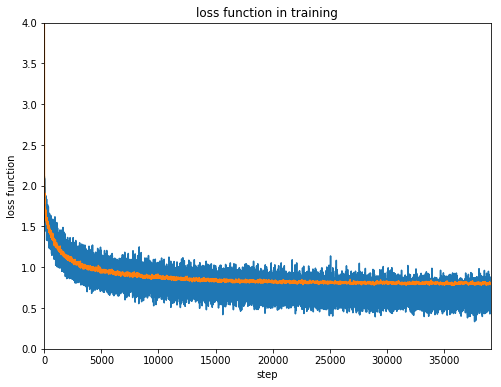

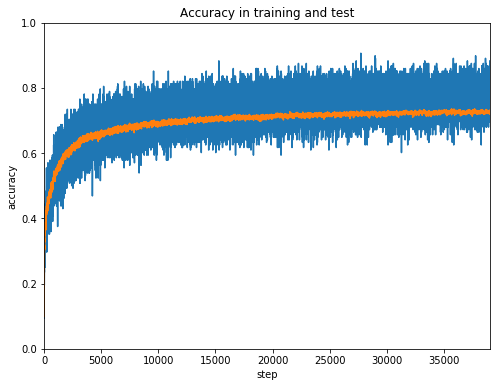

0.7283


In [14]:
batch_size = 128
train_iter = siter(train, batch_size)
with tqdm(total = nepoch) as pbar:
    while train_iter.epoch < nepoch:
        pbar.update(train_iter.is_new_epoch)
        batch = train_iter.next()
        batch = ds.TransformDataset(batch, ohm.flip_labeled)
        xtrain,ttrain = con.concat_examples(batch)
        data = cuda.to_gpu([xtrain,xtest,ttrain,ttest])
        ohm.learning_classification(model,optNN,data,result,1)
        if train_iter.is_new_epoch == 1:
            display.clear_output(wait=True)
            ohm.plot_result2(result[0],result[1],'loss function in training','step','loss function',0.0,4.0)
            ohm.plot_result2(result[2],result[3],'Accuracy in training and test','step','accuracy')
            print(result[3][len(result[3])-1])